In [133]:
from flask import Flask, render_template, request, redirect
from bs4 import BeautifulSoup
import requests
import urllib2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [171]:
def get_sal_data(season):
    data_list = []
    cap = requests.get('http://www.spotrac.com/nba/cap/'+str(season)+'/')
    soup= BeautifulSoup(cap.text,"html.parser")
    table = soup.find('div',{'id':'main','class':' xlarge'}).find()
    sal_cap = str(table)[int(str(table).find('$')+1):int(str(table).find('<br>'))]
    cap_value = float(sal_cap.replace(',',''))/10000
    for pos in ['point-guard','shooting-guard','small-forward','power-forward','center']:
        pos_num = ['point-guard','shooting-guard','small-forward','power-forward','center'].index(pos)
        contract = requests.get('http://www.spotrac.com/nba/rankings/'+str(season)+'/cap-hit/'+pos+'/')
        soup_new= BeautifulSoup(contract.text,"html.parser")
        table = soup_new.find('table',{'class':'datatable noborder'})
        l = table.tbody.find_all('tr')

        for i in l:
            row = [j.get_text().encode('utf-8') for j in i.find_all('td')]
            name = row[2].split('\n')[1]
            sal = int(int(row[3].split('$')[1].replace(',',''))/10000)
            ratio = float(sal)/cap_value
            data_list.append([name,int(pos_num),sal,ratio])
    return data_list

In [411]:
def get_player_data(year):
    advanced_train = 'http://www.basketball-reference.com/leagues/NBA_'+str(year)+'_advanced.html'
    req = requests.get(advanced_train)
    text = BeautifulSoup(req.text, 'html.parser')
    stats = text.find('div',{'id': 'all_advanced_stats'})
    P_list = ['PG','SG','SF','PF','C']
    per_data = {}
    age_data = {}
    min_data = {}
    wS_data = {}
    off_pos = {}
    for i in stats.tbody.find_all('tr'):

        row = [j.get_text().encode('utf-8') for j in i.find_all('td')]

        if len(row)==0:
            continue
        mins = row[5]
        gp = row[4]
        mp = float(mins)/float(gp)
        age = int(row[2])
        if mp > 8.0 and age>24:
            name = str(row[0])
            per = float(row[6])
            wS = float(row[21])
            pos = str(row[1])
            if len(pos)>2:
                plist = pos.split('-')
                pos = plist[0]
            pos_num = P_list.index(pos)
            if name not in per_data.keys() and per>=0 and wS>=0:
                per_data.update({name:per})
                age_data.update({name:age})
                min_data.update({name:mp})
                wS_data.update({name:wS})
                off_pos.update({name:pos_num})
    return per_data,age_data,min_data,wS_data,off_pos

In [412]:
#current factors include veteran rookie status, train models for five positions separately

In [413]:
plotting_data = []
knn_test = []
test_data = [[],[],[],[],[]]
test_names = [[],[],[],[],[]]
cul_data = [[],[],[],[],[]]
names_data = [[],[],[],[],[]]
for season in [2010,2011,2012,2013,2014,2015,2016]:
    print season
    year = season+1
    data_list = get_sal_data(season)
    per_data,age_data,min_data,wS_data,off_pos = get_player_data(year)
    for player in data_list:
        name = player[0]
        pos = player[1]
        salary = player[2]
        ratio = player[3]
        if name in per_data.keys() and salary>50:
            PER = per_data[name]
            WS = wS_data[name]
            off_Pos = off_pos[name]
            age = age_data[name]
            vet = int(age>=35)
            roo = int(age<25)
            mp = min_data[name]
            if off_Pos==pos:
                cul_data[pos].append([salary,ratio,mp,PER,PER**2,WS,vet,roo,mp*PER,age])
                names_data[pos].append(name)
            else:
                cul_data[off_Pos].append([salary,ratio,mp,PER,PER**2,WS,vet,roo,mp*PER,age])
                names_data[off_Pos].append(name)
                cul_data[pos].append([salary,ratio,mp,PER,PER**2,WS,vet,roo,mp*PER,age])
                names_data[pos].append(name)
            plotting_data.append([PER,WS,ratio])
t_season = 2017
t_year = 2018
data_test = get_sal_data(t_season)
per_test,age_test,min_test,wS_test,off_test = get_player_data(t_year)

for player in data_test:
        name = player[0]
        pos = player[1]
        salary = player[2]
        ratio = player[3]
        if name in per_test.keys() and salary>50:
            PER = per_test[name]
            age = age_test[name]
            WS = wS_test[name]
            OFF_POS = off_test[name]
            vet = int(age>=35)
            roo = int(age<25)
            mp = min_test[name]
            if OFF_POS==pos:
               
                test_data[pos].append([salary,ratio,mp,PER,PER**2,WS,vet,roo,mp*PER,age])
                test_names[pos].append(name)
            else:
                test_data[OFF_POS].append([salary,ratio,mp,PER,PER**2,WS,vet,roo,mp*PER,age])
                test_names[OFF_POS].append(name)
                test_data[pos].append([salary,ratio,mp,PER,PER**2,WS,vet,roo,mp*PER,age])
                test_names[pos].append(name)
            knn_test.append([PER,WS,ratio])

2010
2011
2012
2013
2014
2015
2016


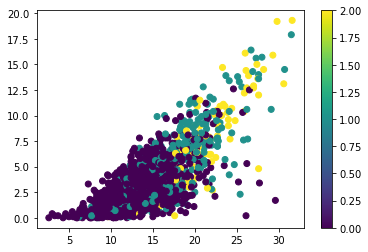

In [565]:
#classification analysis
low_cut = 0.15
high_cut = 0.28
PER_ = np.array(plotting_data)[:,0]
WS_ = np.array(plotting_data)[:,1]
trainX = np.array(plotting_data)[:,0:2]
X_ = np.array(knn_test)[:,0:2]
y_ = np.array(knn_test)[:,2]
y_class = (y_>low_cut)*1+(y_>high_cut)*1
sal_ = np.array(plotting_data)[:,2]
sal_ind = (sal_>low_cut)*1+(sal_>high_cut)*1
plt.scatter(PER_,WS_,c=sal_ind)
plt.colorbar()

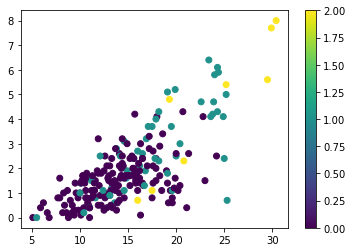

In [566]:
plt.scatter(X_[:,0],X_[:,1],c=y_class)
plt.colorbar()

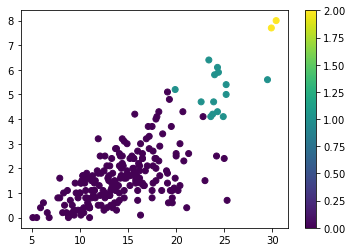

In [570]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=35)
neigh.fit(trainX, sal_ind)
train_pred = neigh.predict(trainX)
classified = neigh.predict(X_)
plt.scatter(X_[:,0],X_[:,1],c=classified)
plt.colorbar()

In [571]:
#training accuracy
print sum((train_pred-sal_ind)==0)*1.0/len(sal_ind)
#testing accuracy
print sum((classified-y_class)==0)*1.0/len(y_class)

0.795411089866
0.79203539823


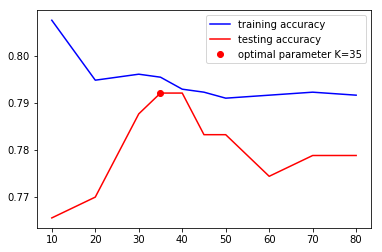

In [569]:
#grid search
train_list = []
test_list = []
K_list = [10,20,30,35,40,45,50,60,70,80]
for K in K_list:
    neigh = KNeighborsClassifier(n_neighbors=K)
    neigh.fit(trainX, sal_ind)
    train_pred = neigh.predict(trainX)
    classified = neigh.predict(X_)
    train_acc = sum((train_pred-sal_ind)==0)*1.0/len(sal_ind)
    test_acc = sum((classified-y_class)==0)*1.0/len(y_class)
    train_list.append(train_acc)
    test_list.append(test_acc)
opt_k = K_list[test_list.index(max(test_list))]
plt.plot(K_list,train_list,'b',label='training accuracy')    
plt.plot(K_list,test_list,'r',label='testing accuracy')
plt.plot(opt_k,max(test_list),'ro',label='optimal parameter K='+str(opt_k))
plt.legend()


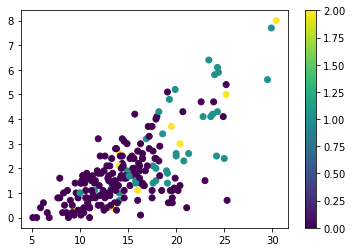

In [579]:
#DCT
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(trainX, sal_ind)
trainY = clf.predict(trainX)
Y_ = clf.predict(X_)
plt.scatter(X_[:,0],X_[:,1],c=Y_)
plt.colorbar()

In [578]:
#training accuracy
print sum((trainY-sal_ind)==0)*1.0/len(sal_ind)
#testing accuracy
print sum((Y_-y_class)==0)*1.0/len(y_class)

0.810070108349
0.734513274336


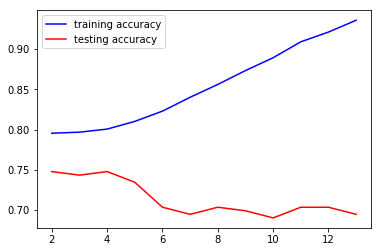

In [575]:
train_list = []
test_list = []
depth_list = [2,3,4,5,6,7,8,9,10,11,12,13]
for depth in depth_list:
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf = clf.fit(trainX, sal_ind)
    trainY = clf.predict(trainX)
    Y_ = clf.predict(X_)
  
    train_acc = sum((trainY-sal_ind)==0)*1.0/len(sal_ind)
    test_acc = sum((Y_-y_class)==0)*1.0/len(y_class)
    train_list.append(train_acc)
    test_list.append(test_acc)
plt.plot(depth_list,train_list,'b',label='training accuracy')    
plt.plot(depth_list,test_list,'r',label='testing accuracy')
plt.legend()

In [525]:
#prepare data for regression models
i = 0
#select a position 0-PG, 1-SG, 2-SF, 3-PF, 4-C
cur_data = np.array(cul_data[i])
cur_names = names_data[i]
if i==1:
    cur_data = np.array(cul_data[1]+cul_data[0])
    cur_names = names_data[1]+names_data[0]
#if i==4:
    #cur_data = np.array(cul_data[3]+cul_data[4])
    #cur_names = names_data[3]+names_data[4]
cur_testname = test_names[i]
cur_test = np.array(test_data[i])
Z = cur_data[:,0]
Y = cur_data[:,1]
X = cur_data[:,2:-1]
testX = cur_test[:,2:-1]
testY = cur_test[:,1]
testZ = cur_test[:,0]

In [529]:
from sklearn.linear_model import LinearRegression,HuberRegressor
from sklearn.metrics import mean_absolute_error
#from sklearn.cross_validation import KFold
#kf = KFold(len(Wins),n_folds=5,shuffle=True)
#pred=[]
#test case Memphis Grizzlies
#clf = Lasso(alpha=0.1)
#clf = LinearRegression()
#epsilon=1 for C,PF,SG,5 for PG,3 for SF
clf = HuberRegressor(epsilon=5,alpha=0)
    # Iterate through folds
#regr.fit(X,Y)
clf.fit(X,Y)
pred = clf.predict(np.array(testX))
print "MAE = "+str(mean_absolute_error(testZ,9909*pred))
print "Test R^2 = "+str(clf.score(testX,testY))
print "Train R^2 = "+str(clf.score(X,Y))   
print clf.coef_,clf.intercept_


MAE = 462.679035379
Test R^2 = 0.599487456666
Train R^2 = 0.579779325883
[-0.00070575 -0.00817469  0.00011821 -0.00726101  0.01755548  0.
  0.00047755] 0.0394395071817


In [530]:
pred_show = []
cur_cap = 9909
for i in range(len(cur_testname)):
    name = cur_testname[i]
    per = round(testX[i][1],1)
    age = int(cur_test[i][-1])
    mp = round(testX[i][0],1)
    ws = round(testX[i][3],1)
    sal_pred = int(pred[i]*cur_cap)
    true_sal = int(testZ[i])
    pred_show.append([true_sal,sal_pred,name,per,ws,mp,age])
sorted(pred_show,reverse=True)

[[3468, 2931, 'Stephen Curry', 29.5, 5.6, 32.5, 29],
 [2870, 1688, 'Kyle Lowry', 19.3, 4.8, 32.8, 31],
 [2853, 2756, 'Russell Westbrook', 25.2, 5.4, 36.1, 29],
 [2853, 1480, 'Mike Conley', 16.0, 0.7, 31.1, 30],
 [2615, 2474, 'Damian Lillard', 22.6, 4.7, 36.6, 27],
 [2565, 1685, 'Jrue Holiday', 15.6, 2.4, 36.6, 27],
 [2459, 2351, 'Chris Paul', 24.9, 4.1, 32.0, 32],
 [2000, 948, 'George Hill', 13.3, 1.2, 27.1, 31],
 [1900, 1460, 'Jeff Teague', 14.9, 1.9, 33.9, 29],
 [1886, 2191, 'Kyrie Irving', 24.3, 6.1, 32.6, 25],
 [1806, 2039, 'John Wall', 20.0, 2.5, 34.0, 27],
 [1700, 1454, 'Goran Dragic', 16.2, 2.1, 31.9, 31],
 [1600, 1188, 'Reggie Jackson', 16.8, 1.9, 27.1, 27],
 [1545, 881, 'Tony Parker', 13.6, 0.6, 21.7, 35],
 [1450, 1708, 'Eric Bledsoe', 19.0, 1.9, 31.0, 28],
 [1427, 1018, 'Ricky Rubio', 12.6, 1.0, 29.1, 27],
 [1200, 2055, 'Kemba Walker', 20.7, 4.3, 34.6, 27],
 [1200, 1127, 'Jeremy Lin', 16.3, 0.1, 25.0, 29],
 [1156, 898, 'Jordan Clarkson', 16.5, 1.4, 22.9, 25],
 [1000, 1368, 'D